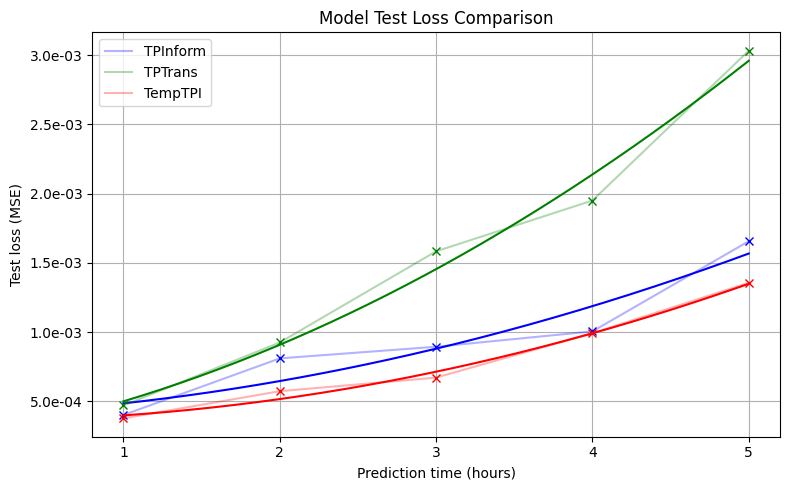

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from scipy.optimize import curve_fit

# Read the CSV file
df = pd.read_csv("results_large_data.csv", sep=",", engine="python")

# Clean column names and remove trailing semicolons if present
df["test_loss"] = df["test_loss"].astype(float)
df["model"] = df["model"].astype(str)

def f_quad(x, a, b, c):  return a*x**2 + b*x + c

# Plot
plt.figure(figsize=(8, 5))
colors = ["b","g","r"]
for col, (model, group) in zip(colors, df.groupby("model")):
    # Fit curve
    x = np.arange(1, len(group) + 1)
    y = group["test_loss"].values
    popt, _ = curve_fit(f_quad, x, y, maxfev=10000)
    # Smooth curve for visualization
    x_smooth = np.linspace(1, len(group), 200)
    y_smooth = f_quad(x_smooth, *popt)

    # Plot real data
    plt.plot(x, y, alpha=0.3, label=f"{model}", c=col)
    plt.plot(x, y, "x", c=col)
    # Plot fitted curve
    plt.plot(x_smooth, y_smooth, alpha=1, c=col)

plt.xlabel("Prediction time (hours)")
plt.ylabel("Test loss (MSE)")
plt.title("Model Test Loss Comparison")
plt.legend()
plt.xticks(range(1,6))
plt.yticks([x*5/10000 for x in range(1,7)])
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
plt.grid(True, which="major")
plt.tight_layout()
plt.show()

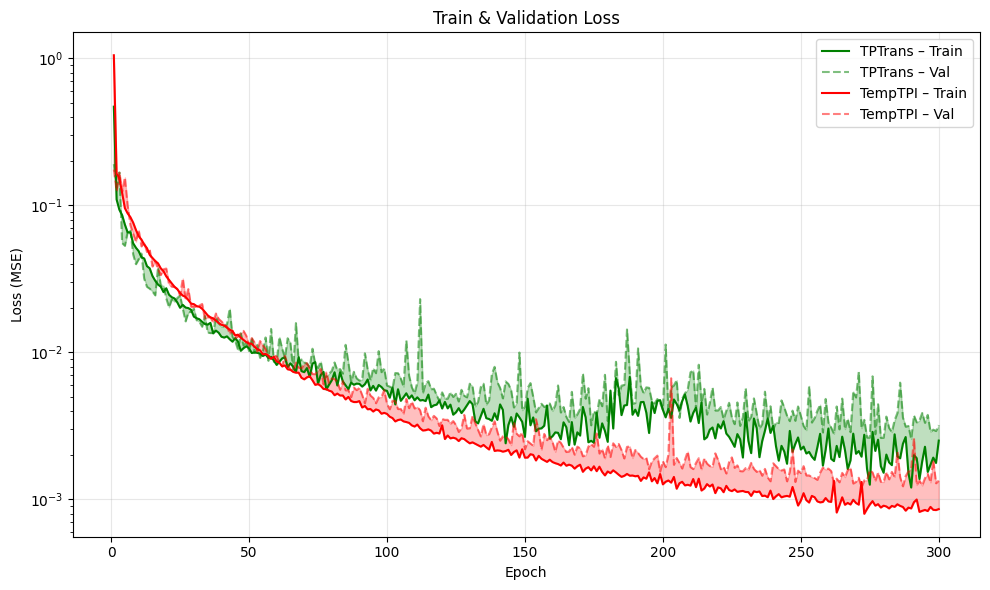

In [15]:
import re
from pathlib import Path
import matplotlib.pyplot as plt

# Patterns to match your log format
EPOCH_RE = re.compile(
    r"Epoch\s+(\d+)/\d+\s*\|\s*Train Loss:\s*([0-9.eE+-]+)\s*\|\s*Val Loss:\s*([0-9.eE+-]+)"
)
TEST_RE = re.compile(r"Test Loss:\s*([0-9.eE+-]+)")

def parse_log(path):
    """
    Parse a training log file with lines like:
    Epoch 1/400 | Train Loss: ... | Val Loss: ...
    Test Loss: ...
    """
    path = Path(path)
    epochs = []
    train_losses = []
    val_losses = []
    test_loss = None

    with path.open("r") as f:
        for line in f:
            line = line.strip()

            # Epoch line
            m = EPOCH_RE.search(line)
            if m:
                epoch = int(m.group(1))
                train = float(m.group(2))
                val = float(m.group(3))
                epochs.append(epoch)
                train_losses.append(train)
                val_losses.append(val)
                continue

            # Test loss line
            t = TEST_RE.search(line)
            if t:
                test_loss = float(t.group(1))

    return {
        "epochs": epochs,
        "train": train_losses,
        "val": val_losses,
        "test_loss": test_loss,
        "name": "TempTPI" if "temptpi" in path.stem else "TPTrans",
    }



def plot_runs(log_paths):
    runs = [parse_log(p) for p in log_paths]

    runs = [r for r in runs if r["epochs"]]
    if not runs:
        print("No valid runs parsed.")
        return

    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    cols = ["g", "r"]
    for i,run in enumerate(runs):
        name = run["name"]
        epochs = run["epochs"]
        train = run["train"]
        val = run["val"]

        # Train (solid)
        ax.plot(
            epochs, train,
            label=f"{name} – Train",
            c=cols[i]
        )

        # Validation (dashed)
        ax.plot(
            epochs, val,
            linestyle="--",
            label=f"{name} – Val",
            alpha=0.5,
            c=cols[i]
        )
        ax.fill_between(
            epochs,
            train,
            val,
            color=cols[i],
            alpha=0.25,       # light transparency keeps plot readable
        )

    ax.set_title("Train & Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss (MSE)")
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


plot_runs([
    "../import_performance_log_files/results_with_large_data/tpt_5h.log",
    "../import_performance_log_files/results_with_large_data/temptpi_5h.log",
])